# BMI Topography to GRASS GIS

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bmi_topography import Topography
import subprocess
import sys

In [2]:
# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

## Create Project

In [29]:
!grass -e -c EPSG:32613 $HOME/bmi-topography-grass/colorado

Creating new GRASS GIS location <colorado>...


## Start GRASS Session

In [30]:
# Start GRASS Session
gj.init("./colorado/PERMANENT/")

In [31]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       13
datum:      wgs84
ellipsoid:  wgs84
north:      1
south:      0
west:       0
east:       1
nsres:      1
ewres:      1
rows:       1
cols:       1
cells:      1



## Fetch Data with `bmi_topography`

In [32]:
width = 0.05
dem = Topography(
    north=40.16 + width,
    south=40.14 - width,
    east=-105.4 + width,
    west=-105.5 - width,
    dem_type="SRTMGL3",
    output_format="GTiff"
)

fname = dem.fetch()

/opt/tljh/user/envs/ivy/lib/python3.11/site-packages/bmi_topography/api_key.py:49: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


## Import DEM into GRASS

In [37]:
# Import
gs.run_command("r.import", input=fname, output="dem", resolution="value", resolution_value=50)

In [38]:
# Change computational region to DEM
gs.run_command("g.region", raster="dem", flags="p")

projection: 1 (UTM)
zone:       13
datum:      wgs84
ellipsoid:  wgs84
north:      4451250
south:      4437850
west:       453100
east:       470150
nsres:      50
ewres:      50
rows:       268
cols:       341
cells:      91388


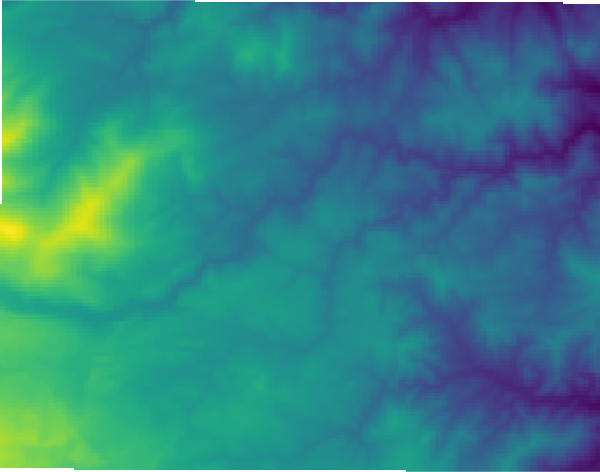

In [39]:
omg = gj.Map()
omg.d_rast(map="dem")
omg.show()

## Insert your GRASS analysis here...

## Some Export Options

### Export to GeoTiff

In [54]:
gs.run_command("r.out.gdal", input="dem", output="dem.tif")

Check your file browser panel and you should see a new file!

### Export to RasterGridModel

In [47]:
# Additional Imports
import grass.script.array as garray
from landlab import RasterModelGrid, imshow_grid

We're going to use info about the raster to determine the spacing and shape of the RasterModelGrid. `raster_info` returns a dictionary where we can get the resolution and dimensions of the raster.

In [49]:
gs.raster_info(map="dem")

{'north': 4451250.0,
 'south': 4437850.0,
 'east': 470150.0,
 'west': 453100.0,
 'nsres': 50.0,
 'ewres': 50.0,
 'rows': '268',
 'cols': '341',
 'cells': '91388',
 'datatype': 'CELL',
 'ncats': '0',
 'min': 1943.0,
 'max': 3286.0,
 'map': 'dem',
 'maptype': 'raster',
 'mapset': 'PERMANENT',
 'location': 'colorado',
 'database': '/home/jupyter-chaedri@ncsu.edu/bmi-topography-grass',
 'date': '"Mon May 20 15:19:34 2024"',
 'creator': '"jupyter-chaedri@ncsu.edu"',
 'title': '""',
 'timestamp': '"none"',
 'units': '"none"',
 'vdatum': '"none"',
 'semantic_label': '"none"',
 'source1': '""',
 'source2': '""',
 'description': '"generated by r.proj"',
 'comments': '"r.proj --quiet location="tmp_r_import_location_ip_172_31_5_210_65659\\0" mapset="PERMANENT" input="dem" method="nearest" memory=300 resolu\\tion=50.0"'}

In [50]:
raster_info = gs.raster_info(map="dem")

# Make sure the east and west resolution is the same (since RasterModelGrid has one xy_spacing value)
assert raster_info['ewres']==raster_info['nsres']

# Get spacing and shape for RasterModelGrid
spacing = raster_info['nsres']
shape = (int(raster_info['rows']), int(raster_info['cols']))

Now that we have the spacing and shape of the array, we'll get the raster as an array and then flip and flatten to match the RasterModelGrid pattern.

In [51]:
# Get GRASS Elevation Raster as np array
elev = garray.array("dem")

# Flip and flatten to match RasterModelGrid node pattern
flip = np.flip(elev, 0)
flat_elev = flip.flatten()

Finally, make the grid object and assign node values!

In [52]:
# Make our RasterModelGrid using info from GRASS
grid = RasterModelGrid(shape, xy_spacing=spacing)
grid.at_node["topographic__elevation"] = flat_elev

/opt/tljh/user/envs/ivy/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Check out the results..

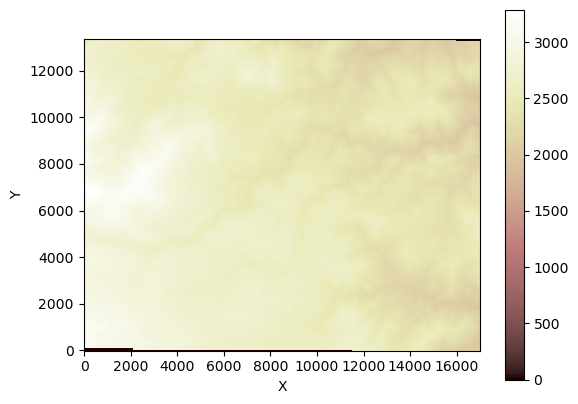

In [48]:
imshow_grid(grid,'topographic__elevation')